In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
from geopy.distance import great_circle
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd


In [109]:
house_csv = r"..\data\cleaned\clean_house.csv"
app_csv = r"..\data\cleaned\clean_app.csv"

house = pd.read_csv(house_csv)
app = pd.read_csv(app_csv)
print(house.head(3))
print(app.head(3))
print(house.columns)

   property_id locality_name  postal_code   latitude  longitude property_type  \
0     11157483         ronse         9600  50.741809   3.607601         HOUSE   
1     11156843     merelbeke         9820  51.019250   3.760957         HOUSE   
2     11161362         forêt         4870  50.563966   5.675489         HOUSE   

  property_subtype     price type_of_sale  number_of_rooms  ...  terrace  \
0            HOUSE  245000.0  BUY_REGULAR              NaN  ...      1.0   
1            HOUSE  315000.0  BUY_REGULAR              NaN  ...      1.0   
2            HOUSE  325000.0  BUY_REGULAR              NaN  ...      1.0   

  terrace_area  garden  garden_area  surface_of_good  number_of_facades  \
0         13.0     1.0        161.0            250.0                2.0   
1         23.0     NaN          NaN             77.0                2.0   
2         16.0     1.0        420.0            572.0                3.0   

   swimming_pool  state_of_building  main_city         province  
0  

# Missing Values

## Create function to make plot
Below we made a function that allows us to make a stacked bar chart that show the proportion of the missing values towards the total of observations.

In [4]:
def bar_missing_values(df):
    # Calculate missing values and non-null values for each column
    missing_values = df.isnull().sum()
    non_null_values = df.notnull().sum()

    # Create a stacked bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(missing_values.index, non_null_values, color='lightgreen', label='Non-Null')
    plt.bar(missing_values.index, missing_values, bottom=non_null_values, color='salmon', label='Missing')

    plt.title('Stacked Bar Chart of Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Values')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

## Stacked bar char
### Houses

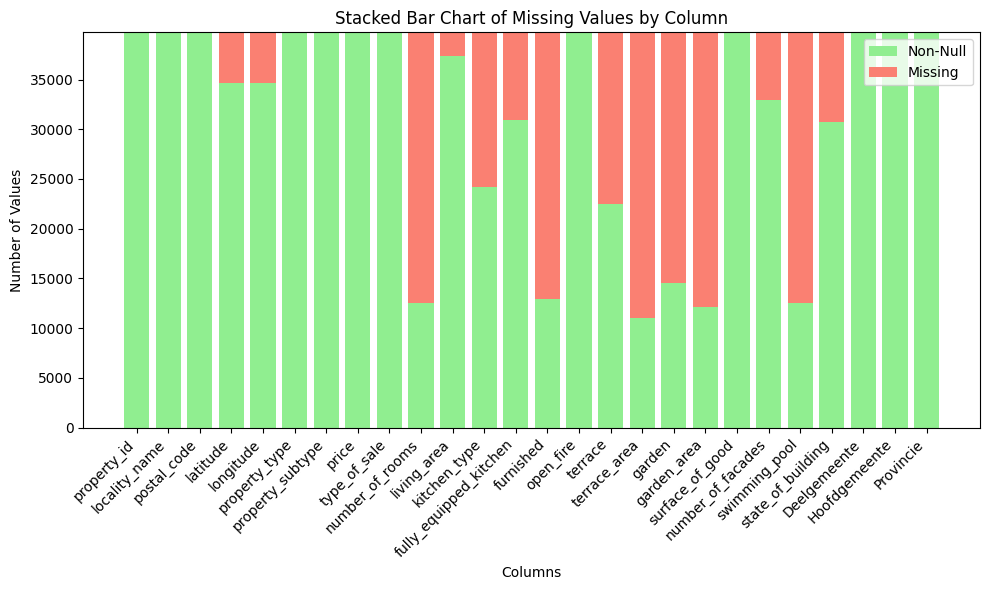

In [5]:
bar_missing_values(house)

### Apartments

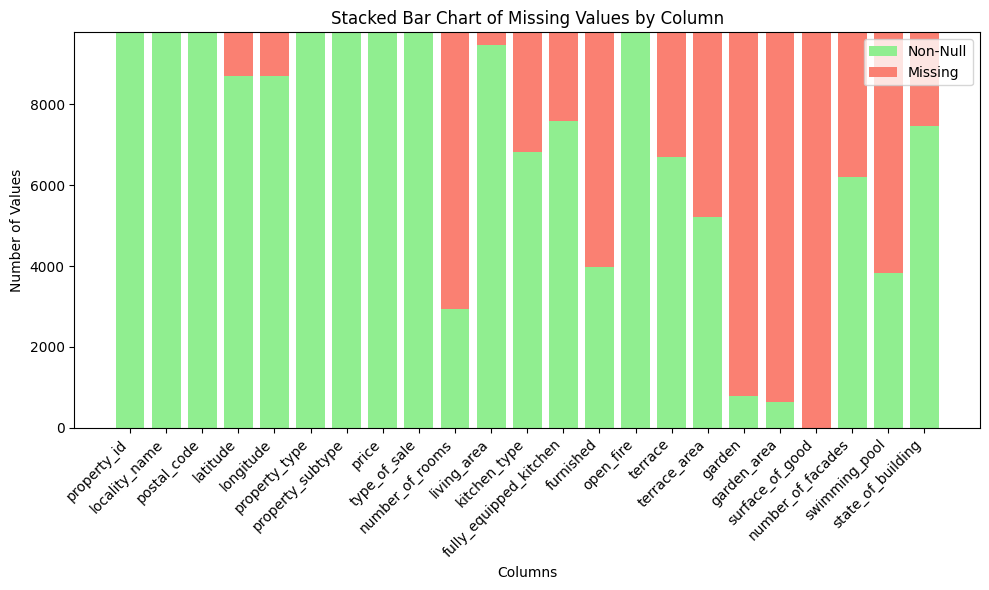

In [5]:
bar_missing_values(app)

## Stacked Bar Chart using percentage

In [6]:
def bar_missing_values_perc(df):
    # Calculate missing values and non-null values for each column
    missing_values = df.isnull().sum()
    non_null_values = df.notnull().sum()
    total_values = missing_values + non_null_values
    missing_values_perc = (missing_values/total_values)*100
    non_null_values_perc = (non_null_values/total_values)*100

    # Create a stacked bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(missing_values_perc.index, non_null_values_perc, color='lightgreen', label='Non-Null')
    plt.bar(missing_values_perc.index, missing_values_perc, bottom=non_null_values_perc, color='salmon', label='Missing')

    plt.title('Stacked Bar Chart of Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

#### Houses

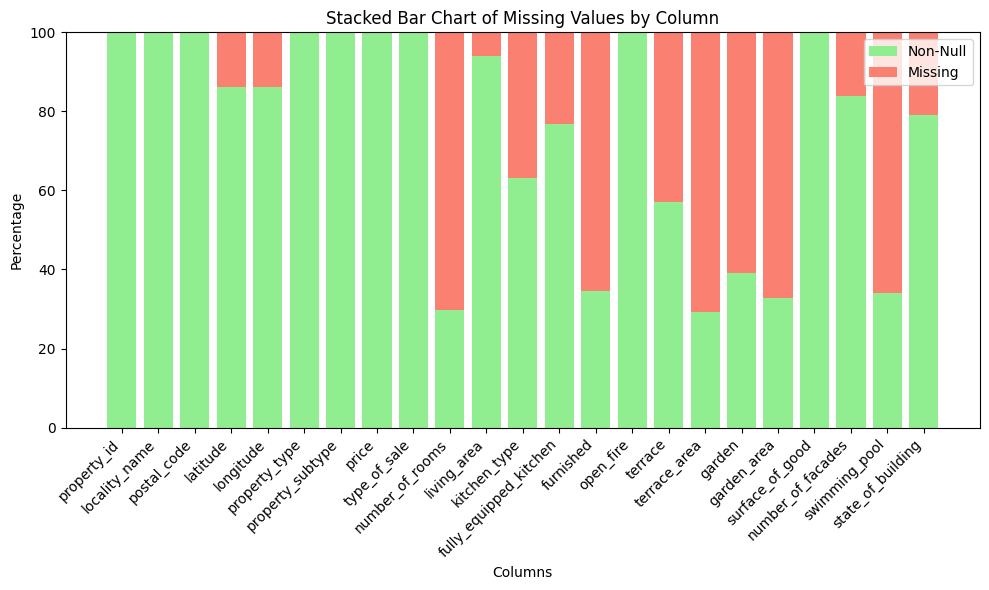

In [7]:
bar_missing_values_perc(house)

For the following we observe a large number of missing values and possible reasons why they might be missing:
- number_of_rooms
- furnished
- terrace
- terrace_area
- garden
- garden_area 
- swimming_pool

The abundance of missing values in the dataset is likely attributed to instances where individuals opted not to complete the corresponding form fields, possibly due to the absence of the specified attributes.

The substantial number of missing values in the "number of rooms" attribute may be attributable to respondents opting to complete a similar attribute, such as "number of bedrooms", etc. 

#### Apartment

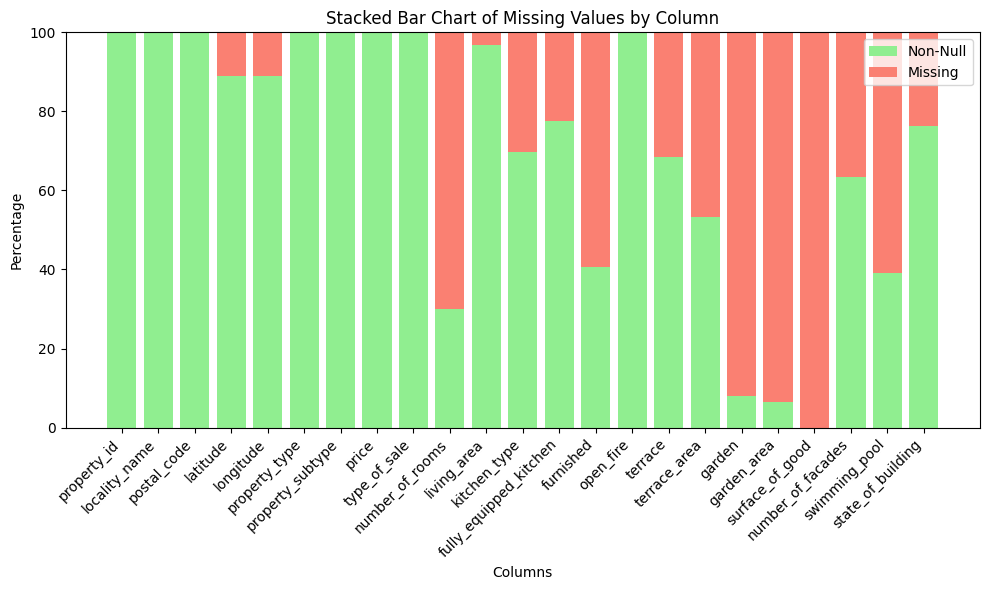

In [8]:
bar_missing_values_perc(app)

We find a similar trend in Apartments. but seems to be more prevalent in garden, garden_area, and surface_of_good.
The complete absence of any value in surface_of_good makes it an easy attribute to completely remove from the Apartment dataset.
Like in Houses, the abundance of missing values in garden can be attributed to the individuals simply not bothering to fill in this form when not there. So, in most of these cases, a None value is actually 0.

The swimming_pool attribute will be discussed in unique values.


## Comparing Houses and Apartments

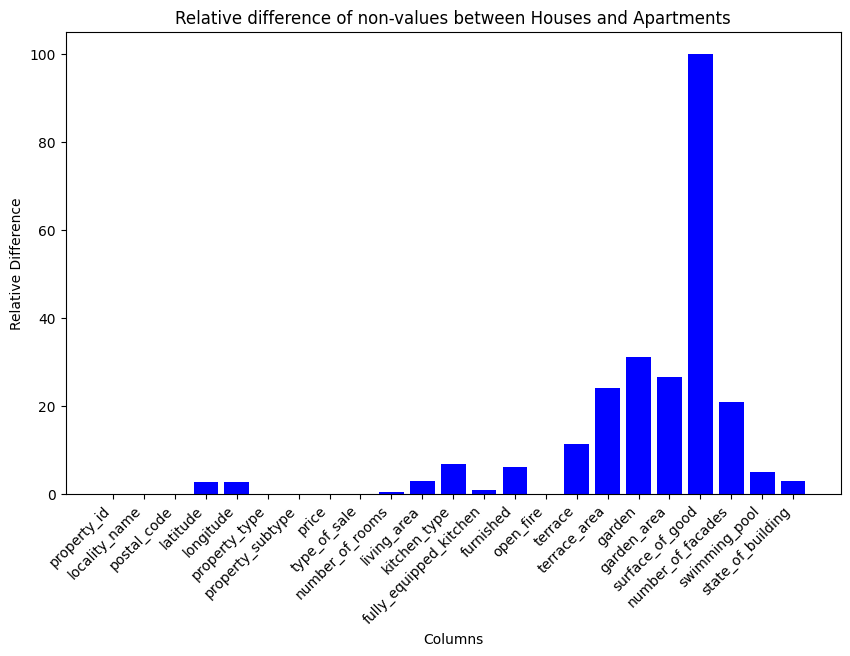

In [9]:
def make_comparison(df1, df2):
    columns = df1.columns
    house_non_null_counts = df1.count()/(df1.count()+df1.isnull().sum())
    app_non_null_counts = df2.count()/(df2.count()+df2.isnull().sum())
    difference = abs(house_non_null_counts - app_non_null_counts)*100
    # Create a line chart
    plt.figure(figsize=(10, 6))
    plt.bar(columns, difference, color='b', label='Difference')

    # plt.plot(columns, house_non_null_counts, marker='o', linestyle='-', color='b', label='House')
    # plt.plot(columns, app_non_null_counts, marker='o', linestyle='-', color='r', label='Apartment')

    #  Customize the plot
    plt.title('Relative difference of non-values between Houses and Apartments')
    plt.xlabel('Columns')
    plt.ylabel('Relative Difference')
    plt.xticks(rotation=45, ha='right')
    # Show the plot
    plt.show()

make_comparison(house,app)

Here, the biggest differences in the count of non-null values between and Houses and Apartments are the terrace, terrace_area, garden, garden_area, surface_of_good and number_of_facades. We will look into this more when looking at unique values. 

# Unique Values


## Create function

In [10]:
def bar_unique(df):
    # Count unique values per column
    df_unique = df.nunique()
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    df_unique.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title('Bar Chart of Unique Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of unique values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

### Houses

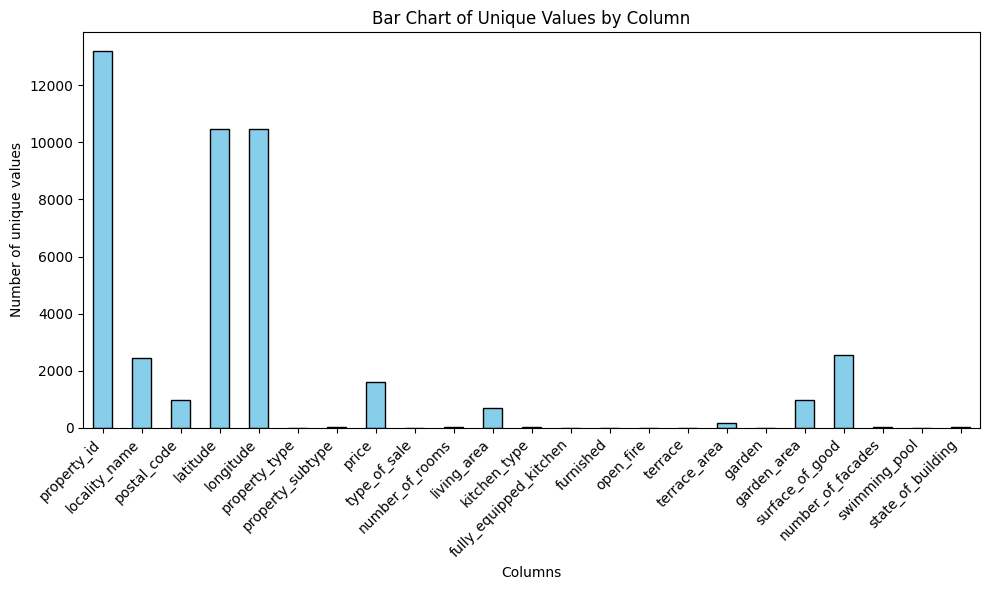

In [11]:
bar_unique(house)

Some have quite large amount of unique values. We would, however like to loo at those attributes with far fewer unique values.

### Make function to limit columns
Only columns that have less then 15 unique values.

In [28]:
def return_column_list(df):
    threshold = 15
    columns_to_keep = df.columns[df.nunique() < threshold]
    return columns_to_keep


### New Dataframes 

In [25]:
house_remove = house[return_column_list(house)]
app_remove = app[return_column_list(app)]

#### House

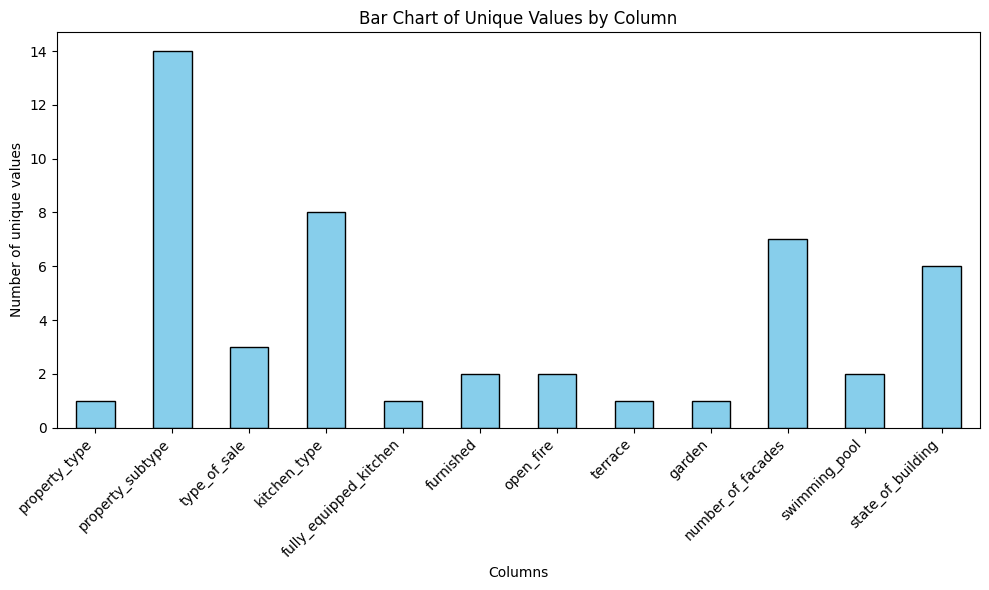

In [26]:
bar_unique(house_remove)

Following attributes have only 1 unique value
- property_type
- fully_equipped_kitchen
- terrace
- garden

Property_type apparently has only one category and should be best removed.
It appears fully_equipped_kitchen, terrace and garden are booleans and have in most cases only 1 or missing value. Like discussed above, the lack of 0 (False) most likely means the observer simply didn't fill in this part of the form due to non-existence of attribute and could therefore be attributed to 0.

However, it is my recommendation to remove terrace and garden, because terrace_area and garden_area provide more information 


In [27]:
for col in house_remove.columns:
    print(col)
    print("------------------------------")
    print(house_remove[col].unique())
    print("==============================")


property_type
------------------------------
['HOUSE']
property_subtype
------------------------------
['HOUSE' 'MIXED_USE_BUILDING' 'APARTMENT_BLOCK' 'BUNGALOW' 'VILLA'
 'EXCEPTIONAL_PROPERTY' 'OTHER_PROPERTY' 'CASTLE' 'COUNTRY_COTTAGE'
 'MANSION' 'FARMHOUSE' 'TOWN_HOUSE' 'MANOR_HOUSE' 'CHALET']
type_of_sale
------------------------------
['BUY_REGULAR' 'PUBLIC_SALE' 'LIFE_ANNUITY']
kitchen_type
------------------------------
['INSTALLED' 'HYPER_EQUIPPED' 'USA_HYPER_EQUIPPED' 'NOT_INSTALLED'
 'SEMI_EQUIPPED' 'USA_SEMI_EQUIPPED' nan 'USA_INSTALLED' 'USA_UNINSTALLED']
fully_equipped_kitchen
------------------------------
[ 1. nan]
furnished
------------------------------
[ 0. nan  1.]
open_fire
------------------------------
[0 1]
terrace
------------------------------
[ 1. nan]
garden
------------------------------
[ 1. nan]
number_of_facades
------------------------------
[ 2.  3.  4. nan  6.  1.  5.  8.]
swimming_pool
------------------------------
[ 0. nan  1.]
state_of_building
---

In [44]:
for col in app_remove.columns:
    print(col)
    print("------------------------------")
    print(app_remove[col].unique())
    print("==============================")

property_type
------------------------------
['APARTMENT']
property_subtype
------------------------------
['FLAT_STUDIO' 'APARTMENT' 'DUPLEX' 'GROUND_FLOOR' 'PENTHOUSE'
 'SERVICE_FLAT' 'LOFT' 'TRIPLEX' 'KOT']
type_of_sale
------------------------------
['BUY_REGULAR' 'PUBLIC_SALE' 'LIFE_ANNUITY']
kitchen_type
------------------------------
['NOT_INSTALLED' 'USA_SEMI_EQUIPPED' 'INSTALLED' nan 'SEMI_EQUIPPED'
 'HYPER_EQUIPPED' 'USA_HYPER_EQUIPPED' 'USA_INSTALLED' 'USA_UNINSTALLED']
fully_equipped_kitchen
------------------------------
[ 1. nan]
furnished
------------------------------
[nan  0.  1.]
open_fire
------------------------------
[0 1]
terrace
------------------------------
[ 1. nan]
garden
------------------------------
[nan  1.]
surface_of_good
------------------------------
[nan]
number_of_facades
------------------------------
[nan  2.  3.  4.  1.  5.]
swimming_pool
------------------------------
[nan  0.  1.]
state_of_building
------------------------------
['TO_BE_DONE_UP

#### Using Seaborn

In [16]:
def seaborn_unique(df):
    unique_counts = df.nunique()

    # Convert the result to a DataFrame for Seaborn
    df_unique_counts = pd.DataFrame({'Column': unique_counts.index, 'Unique Values': unique_counts.values})

    # Create a bar chart using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Column', y='Unique Values', data=df_unique_counts, palette='viridis')

    # Customize the plot
    plt.title('Number of Unique Values in Each Column')
    plt.xlabel('Column')
    plt.ylabel('Unique Values')

    #  Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()

C:\Users\jensd\AppData\Local\Temp\ipykernel_24000\3075539564.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Column', y='Unique Values', data=df_unique_counts, palette='viridis')


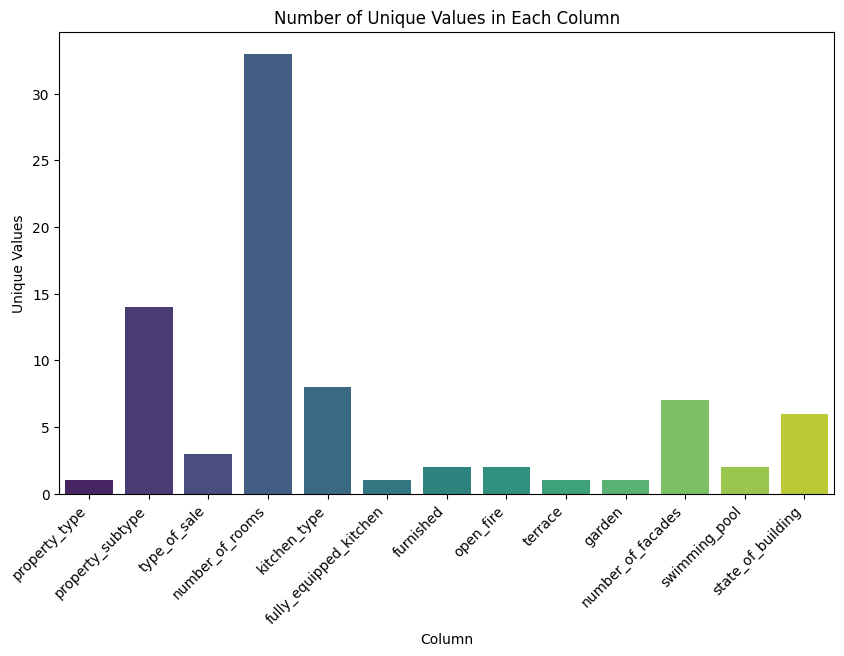

In [18]:
seaborn_unique(house_remove)

### Try Folium

In [36]:


# Filter locations within 5 km radius
radius_km = 5.0
initial_center_coordinates = [house.at[0,'latitude'], house.at[0,'longitude']]

# Create the map
my_map = folium.Map(location=initial_center_coordinates, zoom_start=13)

# Filter locations within 5 km radius
radius_km = 5.0
house_coord = house[['property_id', 'price','latitude', 'longitude']].dropna()

for index, row in house_coord.iterrows():
    property_id, price, latitude, longitude = row
    location_coordinates = [latitude, longitude]
    # Calculate distance using Haversine formula
    distance_km = great_circle(initial_center_coordinates, location_coordinates).kilometers

    # Add marker if within 5 km radius
    if distance_km <= radius_km:
        popup = f"id: {int(property_id)}\nprice: {round(price,2)} EUR"
        folium.Marker(location_coordinates, popup=popup).add_to(my_map)

# Display the new map
my_map


## Prices

In [47]:

fig = px.histogram(house,
                x="price",
                nbins=25)

fig.show()

In [48]:
fig = px.scatter(house, x="property_subtype",y="price")
fig.show()

In [32]:
def make_scatter(df, col):
    fig = px.scatter(df, x=col,y="price")
    fig.show()
df = house[house["living_area"] < 2000]
make_scatter(df, "living_area")

In [40]:
def make_bar_plotly(df):
    df_missing = pd.DataFrame()
    df_missing["not-missing"] = df.count()
    df_missing["missing"] = df.isnull().sum()

    fig = px.bar(df_missing, x=df_missing.index, y=df_missing.columns, title="Missing Values Proportion")
    fig.show()

def make_bar_perc_plotly(df):
    df_missing = pd.DataFrame()
    df_missing["not-missing"] = df.count()/len(df)*100
    df_missing["missing"] = df.isnull().sum()/len(df)*100

    fig = px.bar(df_missing, x=df_missing.index, y=df_missing.columns, title="Missing Values Proportion")
    fig.show()

make_bar_perc_plotly(house)

### BoxPlots all numerical values

In [ ]:
def make_box_plt(df, col):
    fig = px.box(df, y=col)
    fig.show()

numeric_columns = house.select_dtypes(exclude='object')
for col in numeric_columns:
    make_box_plt(house, col)

### Price per m2

In [111]:
house["price_per_m2"] = house["price"]/house["living_area"]

### Aggregate

In [117]:
def aggregate_function(df):
    
    grouped = df.groupby('province').agg(
    mean_price=pd.NamedAgg(column='price', aggfunc='mean'),
    median_price=pd.NamedAgg(column='price', aggfunc='median'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),

    mean_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='mean'),
    median_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='median'),
    max_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='max'),
    min_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='min'),

    lat=pd.NamedAgg(column='latitude', aggfunc='mean'),
    long = pd.NamedAgg(column='longitude', aggfunc='mean')
    

    ).reset_index()
    return grouped

house_grouped = aggregate_function(house)

In [113]:
def make_subset(df,subsetting):
    subset_dictionary = {}
    for subset in df[subsetting].unique():
        subset_dictionary[subset] = df[df[subsetting]==subset]
    return subset_dictionary

In [125]:
subset_dictionary = make_subset(house,"property_subtype")

In [126]:
list_aggregate_subset = {key:aggregate_function(value) for key, value  in subset_dictionary.items()}

In [129]:
for key, value in list_aggregate_subset.items():
    make_bar_plot(key, value, ["mean_price", "median_price"])


In [133]:
subset_dictionary = make_subset(house,"state_of_building")
list_aggregate_subset = {key:aggregate_function(value) for key, value  in subset_dictionary.items()}
for key, value in list_aggregate_subset.items():
    make_bar_plot(key, value, ["mean_price", "median_price"])


In [118]:
def make_bar_plot(key, df, columns):
    # Create traces for each set of values
    trace_list=[]
    for col in columns:
        trace_list.append(go.Bar(x=df["province"], y=df[col], name=col))

    # Layout settings
    layout = go.Layout(
        title=f'Bar Chart for {key}',

        barmode='group'  # 'group' for grouped bars, 'overlay' for overlaid bars
    )
    # Create figure
    fig = go.Figure(data=trace_list, layout=layout)

    # Show the plot
    fig.show()

### Map

In [91]:
def make_map(df):
    # Define a custom marker icon

    map_center  = [df["lat"].mean(), df["long"].mean()]

    # Create the map
    my_map = folium.Map(location=map_center, zoom_start=8)

    for index, row in house_grouped.iterrows():
        Provincie, mean_price, median_price, max_price, min_price, mean_price_m2, median_price_m2, max_price_m2, min_price_m2, lat, long = row
        location_coordinates = [lat, long]
        popup = f"Province: {Provincie}\nMean Price: {round(mean_price,2)} EUR"
        custom_icon = folium.Icon(icon='home', prefix='fa')
        folium.Marker(location_coordinates, 
                    tooltip=popup,
                    icon= custom_icon).add_to(my_map)
        folium.CircleMarker(
            location=location_coordinates,
            radius=mean_price / 100000,  # Adjust the scaling factor as needed
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(my_map)
    # Display the new map
    return my_map


In [87]:
make_map(house_grouped)

In [130]:
# Create a box plot for subsets using Plotly
fig = go.Figure()
df = house
for category in df['property_subtype'].unique():
    subset_data = df[df['property_subtype'] == category]['price']
    fig.add_trace(go.Box(y=subset_data, name=category))

# Add labels and title
fig.update_layout(
    xaxis=dict(title='Category'),
    yaxis=dict(title='Value'),
    title='Boxplot for Subsets'
)

# Show the plot
fig.show()

In [131]:
fig = px.scatter_mapbox(house, lat="latitude", lon="longitude", hover_name="locality_name", hover_data=["price"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [134]:
# Create a heatmap using Mapbox in Plotly with color based on price
def make_heatmap(df):
    fig = go.Figure(go.Densitymapbox(
        lat=df['latitude'],
        lon=df['longitude'],
        z=df['price'],
        radius=20,
        colorscale='Viridis',  # You can choose a different colorscale
        colorbar=dict(title='Price'),
        coloraxis='coloraxis'  # Assign the color axis for custom colors
    ))

    fig.update_layout(
        mapbox=dict(
            style="open-street-map",
            center=dict(lat=df['latitude'].mean(), lon=df['longitude'].mean()),
            zoom=4,
        ),
        coloraxis=dict(colorscale='Viridis'),  # Specify the colorscale for the color axis
    )

    # Show the plot
    fig.show()
make_heatmap(house)

### Prices per municipality

In [138]:
grouped_locality = df.groupby('locality_name').agg(
    price=pd.NamedAgg(column='price', aggfunc='mean'),
    median_price=pd.NamedAgg(column='price', aggfunc='median'),


    mean_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='mean'),
    median_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='median'),

    latitude=pd.NamedAgg(column='latitude', aggfunc='mean'),
    longitude = pd.NamedAgg(column='longitude', aggfunc='mean')
    

    ).reset_index()

make_heatmap(grouped_locality)